# Simulate resting-state dynamics in macaque brain

This demo shows how to simulate and analyze resting-state dynamics in macaque brain.

The results showed here are discussed in Shen et al., 2019 [1]



First, we import all the required dependencies

In [1]:
%pylab nbagg

from tvb.simulator.lab import *
from JC_wong_wang_exc_inh import ReducedWongWangExcInh as ReducedWongWangExcInh

import numpy as np
import time as tm

Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO


## The Connectome

In order to built the macaque brain network, we used a connectome that was constructed from a combination of axonal tract-tracing and diffusion-weighted imaging data, and averaged across subjects (N=9).

In particular, we used a structural connectivity matrix (stored in the data folder of TVB), which is directed (as informed by tracer data) and weighted (as informed by diffusion imaging data). 

In the following, the connectome is loaded and then, plotted. 

In [39]:
# Load the connectivity data from the directory tvb_data
con = connectivity.Connectivity.from_file('/Applications/TVB_Distribution/my_tvb_workspace/tvb-data/tvb_data/macaque/connectivity_84.zip') 

nregions = len(con.region_labels)                         #number of regions
con.weights = con.weights - con.weights*np.eye(nregions)  #remove self-connection
con.weights = con.weights / np.max(con.weights)           #normalized to its maximum value
con.speed = np.array([4.0])                               #time delays

con.configure()

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


<IPython.core.display.Javascript object>


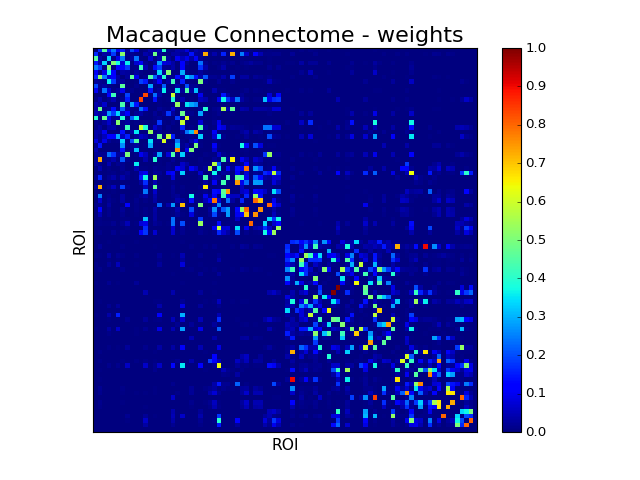

<IPython.core.display.Javascript object>


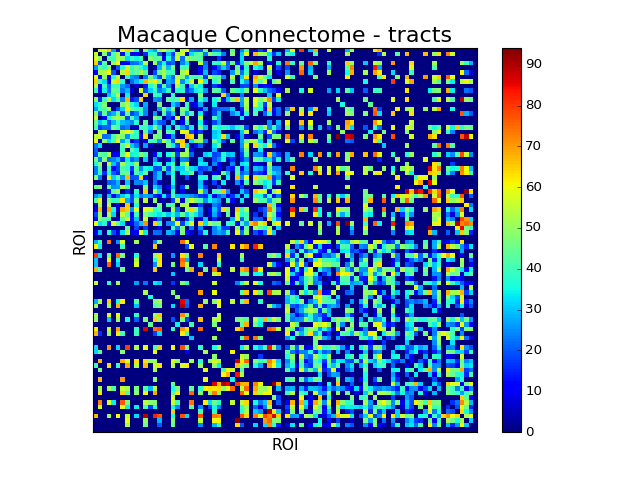

In [40]:
# Visualize the structural connectivity matrix
# weights
fig1=figure()
imshow(con.weights, interpolation='nearest', aspect='equal')
xticks([])
yticks([])
cb=colorbar()
xlabel('ROI', fontsize=14)
ylabel('ROI', fontsize=14)
title('Macaque Connectome - weights', fontsize=20)

#tracts
fig2=figure()
imshow(con.tract_lengths, interpolation='nearest', aspect='equal')
xticks([])
yticks([])
cb=colorbar()
xlabel('ROI', fontsize=14)
ylabel('ROI', fontsize=14)
title('Macaque Connectome - tracts', fontsize=20)

show()

## The simulation

Once the brain network is defined, it is possible to simulate its activity by choosing the intrinsic dynamics of each brain region. Here, we simulate resting-state dynamics using the reduced Wong Wang model with the interconnected populations of excitatory and inhibitory neurons (Deco et al. 2014 [3]).

In order to convert the synaptic activity in BOLD signals, we used the Balloon-Windkessel method (Friston et al., 2000 [4]) using the default parameters value implemented in TVB.

In [3]:
# Set the parameter of the resting state simulation
sim = simulator.Simulator(model=ReducedWongWangExcInh(),
                        connectivity=con,
                        conduction_speed=np.float(con.speed),
                        coupling=coupling.Linear(a=np.array([0.298])),
                        integrator=integrators.EulerStochastic(dt=0.1, noise=noise.Additive(nsig=np.array([(0.0255**2)/2, (0.0255**2)/2]))),
                        monitors=(monitors.Bold(period=1e3),
                                  monitors.TemporalAverage(period=1e3)),
                        simulation_length=600e3).configure()

# Run the resting-state simulation
print("Starting simulation...")
tic = tm.time()

(bold_time, bold_data), _ = sim.run()

print("Finished simulation.")
print("execute for" + str(tm.time()-tic))

The simulated BOLD signals can be visualized using matplotlib library.

<IPython.core.display.Javascript object>


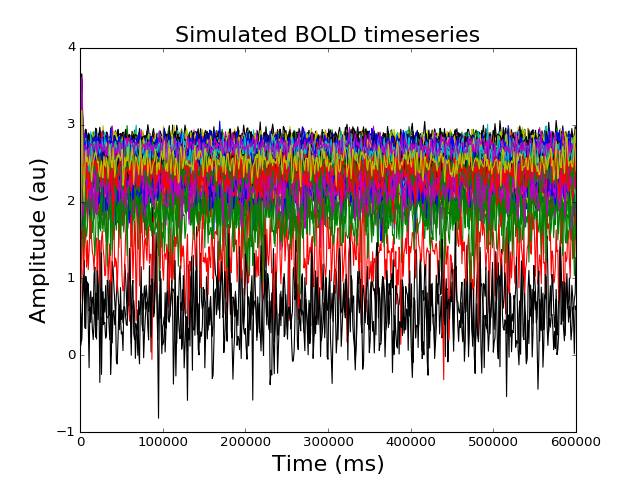

In [4]:
# Display the simulated BOLD timeseries
plt.subplots()
plt.plot(bold_time,bold_data[:,0,:,0])
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated BOLD timeseries', fontsize=20)
plt.show()

## Analysis

The simulated BOLD signals can be analyzed in different ways. 

### Functional Connectivity

In particular, here, we focus on the Functional Connectivity (FC), a metric which is able to infer the strength of functional connections.
There are several metrics to estimate FC; TVB uses the Pearson Correlation Coefficient (Biswal et al., 1995 [5]).

In [5]:
## Calculate the FC matrix for the bold timeseries

from tvb.datatypes.time_series import TimeSeriesRegion
import tvb.analyzers.correlation_coefficient as corr_coeff

# Build the time series object
tsr = TimeSeriesRegion(connectivity=sim.connectivity,
                       data=bold_data,
                       sample_period=sim.monitors[1].period)
tsr.configure()

# Create and evaluate the analysis
corrcoeff_analyser = corr_coeff.CorrelationCoefficient(time_series=tsr)
corrcoeff_data = corrcoeff_analyser.evaluate()
corrcoeff_data.configure()

# Store the results
FC = corrcoeff_data.array_data[..., 0, 0]
FCz = arctan(FC)

   INFO  result shape will be: (84, 84, 2, 1)


<IPython.core.display.Javascript object>


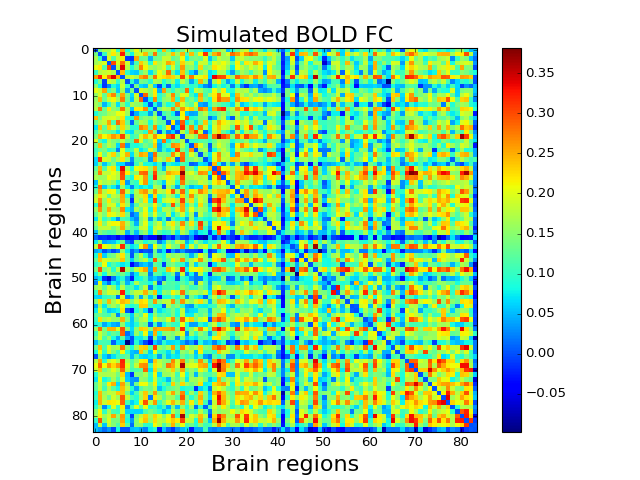

In [7]:
# Display the simulated BOLD FC
plt.subplots()
plt.imshow(FCz-FCz*np.eye(nregions), interpolation='nearest', aspect='equal', cmap='jet')
cb=colorbar()
plt.xlabel('Brain regions', fontsize=20)
plt.ylabel('Brain regions', fontsize=20)
plt.title('Simulated BOLD FC', fontsize=20)
plt.show()

## References

[1] Shen K, Bezgin G, Schirner M, Ritter P, Everling S, McIntosh AR. "A macaque connectome for large-scale network simulations in TheVirtualBrain". Nature Sci Data (2019) 6:123.

[2] Markov NT, Ercsey-Ravasz MM, Ribeiro Gomes AR et al. "A weighted and directed interareal connectivity matrix for macaque cerebral cortex". Cereb Cortex 24, 17–36 (2014).

[3] Deco G et al. "How local excitation-inhibition ratio impacts the whole brain dynamics". J. Neurosci. 34, 7886–98 (2014).

[4] Friston KJ, Mechelli A, Turner R, Price CJ. "Nonlinear responses in fMRI: The balloon model, Volterra kernels, and other hemodynamics". Neuroimage 12, 466–477 (2000).

[5] Biswal B, Zerrin Yetkin F, Haughton VM, Hyde JS (1995) "Functional connec- tivity in the motor cortex of resting human brain using echo-planar MRI". Magn Reson Med 34:537–541.